In [8]:
#If th openai api key is not set already, please set it here.
import os
if 'OPENAI_API_KEY' not in os.environ:  
     os.environ['OPENAI_API_KEY'] = 'your key'

In [6]:
from amadeusgpt.main import AMADEUS
from amadeusgpt.config import Config
import amadeusgpt
from pathlib import Path
import matplotlib.pyplot as plt
import cv2


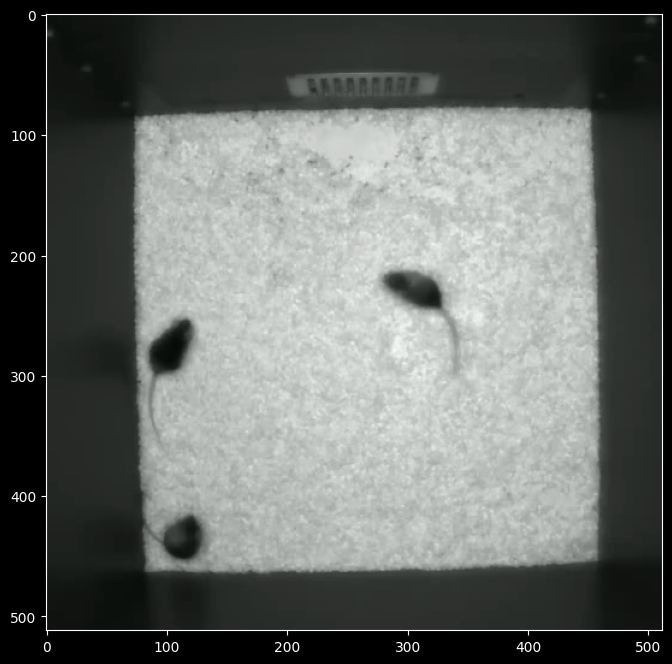

In [7]:
amadeus_root = Path(amadeusgpt.__file__).parent.parent
config = Config(amadeus_root / "amadeusgpt/configs/MABe_template.yaml")

config['keypoint_info']['keypoint_file_path'] = str(amadeus_root / config['keypoint_info']['keypoint_file_path'])
config['video_info']['video_file_path'] = str(amadeus_root / config['video_info']['video_file_path'])
video_path = config['video_info']['video_file_path'] 

cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, config['video_info']['scene_frame_number'])
    # Read the frame
    ret, image = cap.read()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cap.release()
plt.imshow(image)
    

In [8]:
amadeus = AMADEUS(config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0 $
current total tokens 553
The image shows a top-down view of three small animals, likely mice, in a confined space with a textured floor. The background appears to be a controlled environment, possibly a laboratory setting. There is a vent or some sort of grid visible at the top of the image.

Here is the filled json string based on the description:

```json
{
    "description": "Top-down view of three small animals, likely mice, in a confined space with a textured floor. There is a vent or grid visible at the top of the image.",
    "individuals": 3,
    "species": "topview_mouse",
    "background_objects": ["vent"]
}
```


In [9]:
from IPython.display import Markdown, display
from IPython.display import Video
def parse_result(amadeus, qa_message):
    display(Markdown(qa_message['chain_of_thought']))
    sandbox = amadeus.sandbox
    qa_message = sandbox.code_execution(qa_message)
    sandbox.render_qa_message(qa_message)
    print ('after executing the function')
    display(qa_message['meta_info'])
    print (f'videos generated to {qa_message["out_videos"]}')
    print ('Open it with media player if it does not properly display in the notebook')
    if qa_message['out_videos'] is not None:
        for video_path in qa_message['out_videos']:

            display(Video(video_path, embed=True))

    display(Markdown(str(qa_message['function_rets'])))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.02 $
current total tokens 3381


To address the query, we need to identify events where the animals are "watching" each other. The criteria for "watching" are:

1. The distance between animals is less than 260 and larger than 50.
2. The head angle between animals is less than 15 degrees.
3. The smooth window size is 15.

We can achieve this by using the `get_animals_animals_events` function from the `AnimalBehaviorAnalysis` class. This function allows us to specify multiple conditions (queries) that involve interactions between animals.

Here's how we can proceed:

1. Use the `get_animals_animals_events` function to capture events where the distance between animals is within the specified range (50 < distance < 260).
2. Use the same function to capture events where the head angle between animals is less than 15 degrees.
3. Combine these events using the `get_composite_events` function with the `logical_and` composition type to ensure both conditions are met simultaneously.

Now, let's write the code to achieve this:

```python
def get_watching_events(config: Config):
    '''
    Parameters:
    ----------
    config: Config
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(config)
    
    # Define the queries for the conditions
    distance_query = ['distance>50', 'distance<260']
    head_angle_query = ['relative_head_angle<15']
    
    # Get events for the distance condition
    distance_events = analysis.get_animals_animals_events(
        cross_animal_query_list=distance_query,
        bodypart_names=None,
        otheranimal_bodypart_names=None,
        min_window=1,
        max_window=100000,
        smooth_window_size=15
    )
    
    # Get events for the head angle condition
    head_angle_events = analysis.get_animals_animals_events(
        cross_animal_query_list=head_angle_query,
        bodypart_names=None,
        otheranimal_bodypart_names=None,
        min_window=1,
        max_window=100000,
        smooth_window_size=15
    )
    
    # Combine the events using logical_and
    watching_events = analysis.get_composite_events(
        events_A=distance_events,
        events_B=head_angle_events,
        composition_type="logical_and",
        max_interval_between_sequential_events=0,
        min_window=1,
        max_window=100000
    )
    
    return watching_events
```

This function will return the events where the animals are "watching" each other based on the specified criteria.

after executing the function


{'description': 'Top-down view of three small animals, likely mice, in a confined space with a textured floor. There is a vent or grid visible at the top of the image.',
 'individuals': 3,
 'species': 'topview_mouse',
 'background_objects': ['vent']}

videos generated to ['results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_0.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_1.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_2.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_3.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_4.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_5.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_6.mp4']
Open it with media player if it does not properly display in the notebook


[<amadeusgpt.analysis_objects.event.Event object at 0x2967bd540>, <amadeusgpt.analysis_objects.event.Event object at 0x2967bff10>, <amadeusgpt.analysis_objects.event.Event object at 0x2967bf940>, <amadeusgpt.analysis_objects.event.Event object at 0x2967bc310>, <amadeusgpt.analysis_objects.event.Event object at 0x2967bdf60>, <amadeusgpt.analysis_objects.event.Event object at 0x2967beb90>, <amadeusgpt.analysis_objects.event.Event object at 0x2967bd150>]

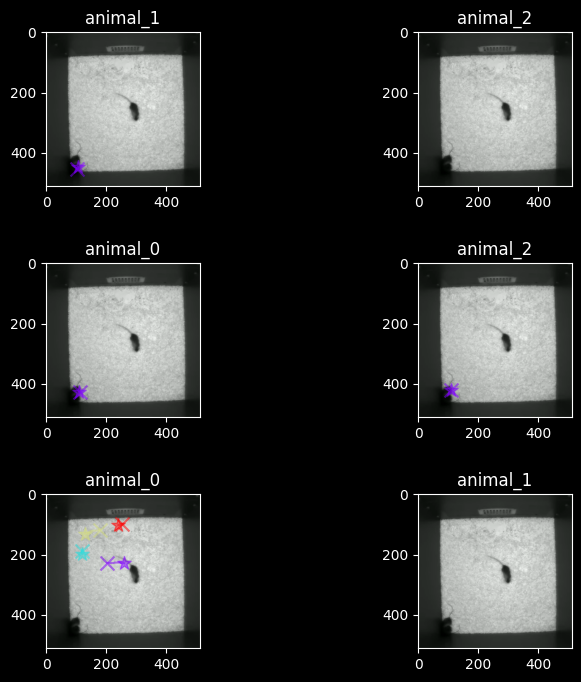

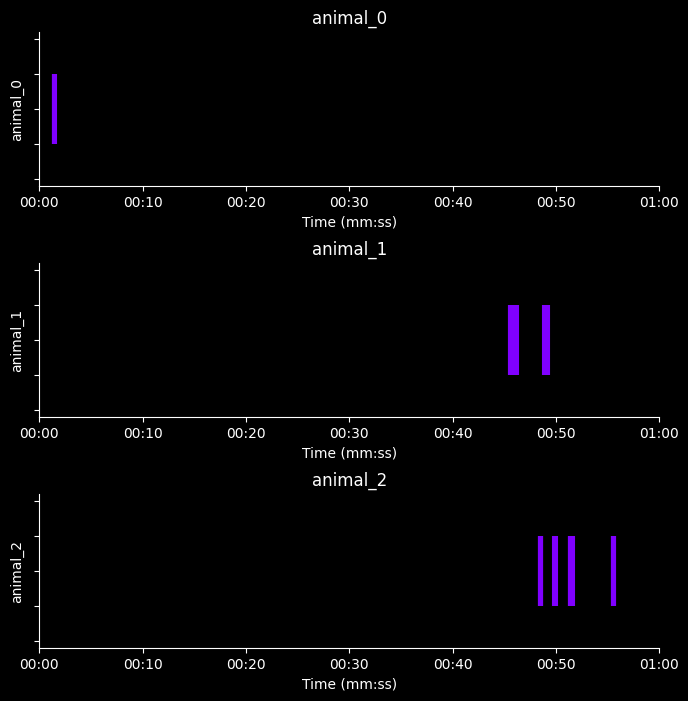

In [10]:
query = "Define watch as a social behavior where distance between animals is less than 260  \
and larger than 50 and head angle between animals is less than 15. The smooth_window_size is 15. Get watching"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

### You can get a list of binary masks (equivalent to ethogram) for the underlying behavior, if your query is about retriving a described behavior

In [11]:
# the return masks is of shape (num_of_events, video_length)
# where each boolean array of (video_length,) is binary where True indicates whether the behavior is happening at that frame
masks = qa_message.get_masks()
print (masks.shape)

(7, 1800)


### You can reuse the task program crafted by LLM

In [18]:
task_programs = amadeus.get_task_programs()
for k,v in task_programs.items():
    print (k)

get_watching_events


### You can use a new config here to run the same task program in a different movie file

<IPython.core.display.Markdown object>

after executing the function


None

videos generated to ['results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_0.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_1.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_2.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_3.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_4.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_5.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_6.mp4']
Open it with media player if it does not properly display in the notebook


[<amadeusgpt.analysis_objects.event.Event object at 0x2ab43abc0>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43ada0>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43be20>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43a170>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43be80>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43a920>, <amadeusgpt.analysis_objects.event.Event object at 0x2ab43a8f0>]

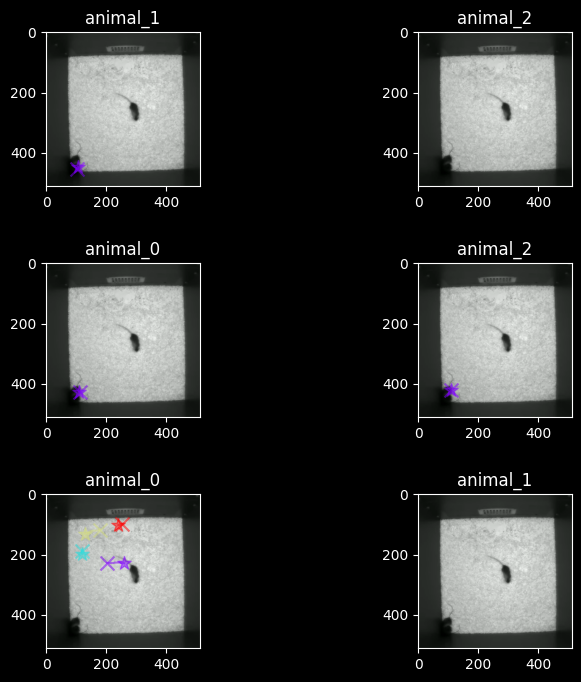

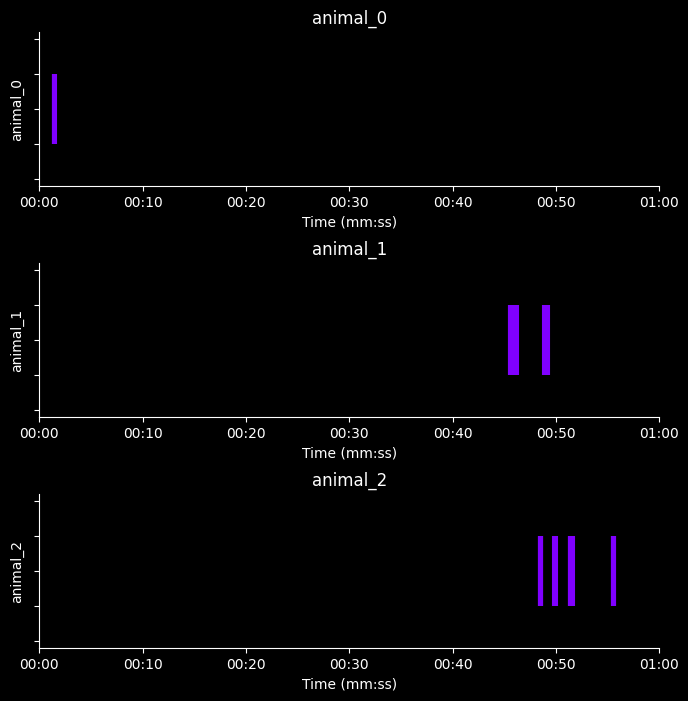

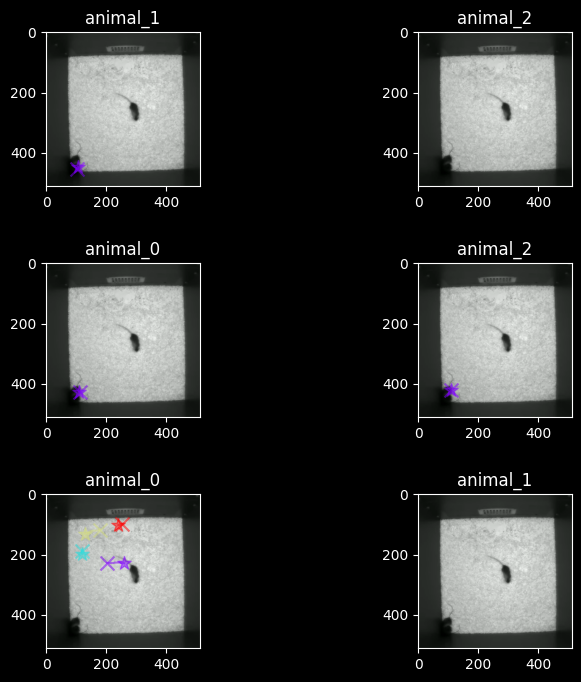

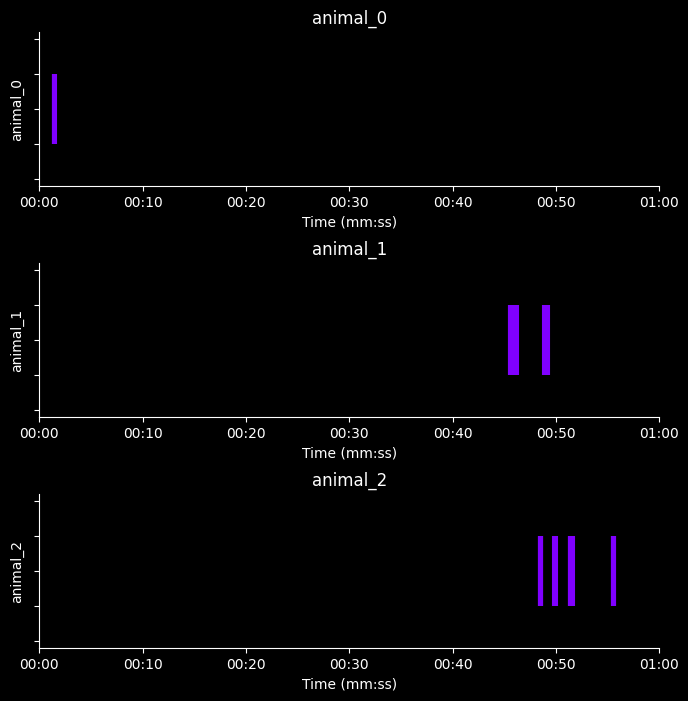

In [15]:
from copy import deepcopy
new_config = deepcopy(config)
#new_config['video_info']['video_file_path'] =  'new movie file'
#new_config['keypoint_info']['keypoint_file_path'] =  'new keypoint file'

qa_message = amadeus.run_task_program(new_config, 'get_watching_events')
parse_result(amadeus, qa_message)

### How to retrieve results using the query

In [ ]:
results = amadeus.get_results()
for key, qa_message in results.items():
    print (key)
    print (qa_message.get_masks().shape)

### Save the results to the result folder

In [ ]:
amadeus.save_results()

### Load results 

In [ ]:
amadeus.load_results()